# Imports

In [ ]:
!pip install --upgrade cvxpy
!pip install mosek

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.4 MB 9.4 MB/s 


In [ ]:
from sklearn import linear_model
from scipy.optimize import curve_fit
from scipy.optimize import nnls
import cvxpy as cp
import numpy as np
import scipy as sp
# import dykstra 
import matplotlib.pyplot as plt
# import pwlf
import matplotlib.animation as animation
from matplotlib import rc

rc('animation', html='jshtml')

In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap, nn
from jax import random

# Dynamic Fisher Market w/ linear Fitted Value Iteration

## Library

#### Utilities

In [ ]:
################### Utility Functions ##########################

def get_linear_util(demands, valuations):
    util = np.sum(demands * valuations, axis = 1) 
    return util


def get_leontief_util(demands, valuations):
    util =  np.min(demands/valuations.clip(min = 0.001), axis = 1) 
    return util

def get_cd_util(demands, valuations):
    util = np.sum(np.log(demands.clip(min = 0.001))*valuations, axis = 1) 
    return util


#################### Utility Gradient Functions #####################
def get_linear_util_gradient(allocations, valuations):
    return valuations

def get_leontief_util_gradient(allocations, valuations):
    grad_matrix = []
    argmins = np.argmin(allocations/valuations.clip(min = 0.001), axis = 0)
    marginal_utils = np.zeros(allocations.shape)
    
    for buyer in range(allocations.shape[0]):
      marginal_utils[buyer, argmins[buyer] ] = 1 / valuations[buyer, argmins[buyer]].clip(min = 0.001)
    
    return marginal_utils

def get_cd_util_gradient(allocations, valuations):
    # return ( np.prod(np.power(allocations, valuations), axis = 1)*( valuations / allocations.clip(min = 0.001) ).T).T
    return ( valuations / allocations.clip(min = 0.001) )
################### Projection Onto Budget Set ##########################


def project_onto_half_space(X, beta, p, b):
  offsets = ((X @ p + beta - b).clip(min= 0))/(np.linalg.norm(p)**2).clip(min= 10e-5)

  X_proj = X - (offsets*np.tile(p, reps = (b.shape[0], 1)).T).T
  beta_proj = beta - offsets
  
  return (X_proj, beta_proj)


def project_onto_positive_ortanth(X, beta, p, b):

  return (X.clip(min = 0), beta.clip(min = 0))

def project_to_bugdet_set(X, beta, p, b):
  iter = 0
  P_X, P_beta = np.zeros(X.shape), np.zeros(b.shape[0])
  Q_X, Q_beta = np.zeros(X.shape), np.zeros(b.shape[0])
  X_proj_y, beta_proj_y = X, beta
  X_proj_x, beta_proj_x = np.ones(X.shape), np.ones(b.shape[0])
  
  X_proj_prev, beta_proj_prev = X.copy(), beta.copy()
  change = float("inf")
  iter = 0
  while np.any(X_proj_x @ p + beta_proj_x - b >  10e-4) or np.any(X_proj_x < 0) or np.any(beta_proj_x < 0) :
  # while iter <= 1000:
    iter += 1
    # print("iterations", iter, "error: ", change)
    X, beta = project_onto_positive_ortanth(X, beta )
    X, beta = project_onto_half_space(X, beta )
    
    # print("proj", X_proj_x, beta_proj_x)
    P_X, P_beta = (P_X + X_proj_y - X_proj_x, P_beta + beta_proj_y - beta_proj_x)
    X_proj_y, beta_proj_y = project_onto_half_space(X_proj_x + Q_X, beta_proj_x + Q_beta, p, b)
    Q_X, Q_beta = Q_X + X_proj_x - X_proj_y, Q_beta + beta_proj_x- beta_proj_y
    
    change = np.linalg.norm(X_proj_prev - X_proj_x) + np.linalg.norm(beta_proj_prev - beta_proj_x)
    X_proj_prev, beta_proj_prev = X_proj_x.copy(), beta_proj_x.copy()
  
  assert np.all(X_proj_x @ p + beta_proj_x - b <=  10e-2) and np.all(X_proj_x >= 0) and np.all(beta_proj_x >= 0) 
  # print("proj", X_proj_x, beta_proj_x)
  return X_proj_x, beta_proj_x
  # shadow_demands = np.zeros((X.shape[0], X.shape[1] + 1))
  # shadow_prices = np.zeros(X.shape[1] + 1)
  # shadow_demands[:, :-1] = X 
  # shadow_demands[:, -1] = beta

  # shadow_prices[:-1] = p
  # shadow_prices[-1] = 1
  
  # P, Q = np.zeros((X.shape[0], X.shape[1] + 1))
  # (1/np.linalg.norm(shadow_prices)**2).clip(min= 0.00000001)*((shadow_demands @ shadow_prices - b).clip(min= 0)* np.tile(shadow_prices, reps = (b.shape[0], 1)).T).T
  # while (np.linalg.norm((shadow_demands @   shadow_prices - b).clip(min = 0)) < 1):
      
  #     shadow_demands -= (1/np.linalg.norm(shadow_prices)**2).clip(min= 0.00000001)*((shadow_demands @ shadow_prices - b).clip(min= 0)* np.tile(shadow_prices, reps = (b.shape[0], 1)).T).T
  #     shadow_demands = shadow_demands.clip(min = 0)
      
  
  
  # return (shadow_demands[:, :-1], shadow_demands[:, -1])

################### Min-Max Objective Functions ##########################

def get_linear_obj(prices, demands, budgets, valuations):
  utils = np.sum(valuations * demands, axis = 1)
  return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


def get_leontief_obj(prices, demands, budgets, valuations):
    utils = np.min(demands/valuations, axis = 1)
    return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


def get_cd_obj(prices, demands, budgets, valuations):
    utils = np.prod(np.power(demands, valuations), axis= 1)
    return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


################### Heuristic objective function ##########################
def get_global(X, get_obj, prices, budgets, valuations, value_coef, value_intercept):
  num_buyers = budgets.shape[0]
  num_goods = prices.shape[0]
  X = X.reshape((num_buyers, num_goods + 1))
  
  demands = X[:, :-1]
  savings = X[:, -1]
  demands = demands.clip(min = 0.0001)
  savings = savings.clip(min = 0.0001)
  
  return -(get_obj(prices, demands, budgets-savings, valuations) + discount*(value_coef.T @ savings + value_intercept) )

### Test JAX

In [ ]:
from jax import device_put

demands = np.random.rand(2,2)
demand=demands[0]
demand = device_put(demand)
valuations = np.array([[21.26920423, 33.45640665],
 [45.06020981, 23.52635807]])
valuation = device_put(valuations[0])

#### Linear

In [ ]:
def get_linear_obj(prices, demands, budgets, valuations):
  utils = jnp.sum(valuations * demands, axis = 1)
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils.clip(0.001)))

def get_linear_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  num_buyers = budgets.shape
  next_budgets = jnp.array([savings * ir + jnp.ones(num_buyers) * 9.5 for ir in [0.9, 1.0, 1.1, 1.2, 1.5]])
  return get_linear_obj(prices, demands, budgets-savings, valuations) + jnp.sum(jnp.array([discount*(next_budget.T @ value_coef + value_intercept) for next_budget in next_budgets]))/5

prices = device_put(np.array([10.0,10.0, 10.0, 10.0, 10.0]))
demands = device_put(np.array([[2.0,2.1, 1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4]]))
budgets = device_put(np.array([10,10,10,10,10]))
savings = device_put(np.array([0.01,0.01,0.01,0.01,0.01]))
value_coef = device_put(np.repeat(1, 5))
value_intercept = 10.0

print(get_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_linear_value = grad(jit(get_linear_value), argnums=1)
savings_grad_linear_value = grad(jit(get_linear_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


spendings = budgets - savings
utils = get_linear_util(demands, valuations).clip(min = 0.01)
marginals = get_linear_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

235.76363
___________________JAX___________________
[[1.1001688  1.6552472  0.11626878 1.6271471  1.4705926 ]
 [1.5033286  0.40810072 2.5890772  0.92718375 1.0227238 ]
 [0.4190575  0.8814333  0.91888845 2.5100925  1.9107076 ]
 [1.3200989  2.5682924  0.11697298 0.64381766 0.1438421 ]
 [0.0962974  1.1652519  2.364608   1.5549781  1.5993317 ]]
[-2.1107497 -0.9964962 -1.9546533 -1.5574698 -1.6602745]
___________________BY HAND___________________
[[1.1001688  1.6552472  0.11626878 1.6271471  1.4705926 ]
 [1.5033286  0.40810072 2.5890772  0.92718375 1.0227238 ]
 [0.4190575  0.8814333  0.91888845 2.5100925  1.9107076 ]
 [1.3200989  2.5682924  0.11697298 0.64381766 0.1438421 ]
 [0.0962974  1.1652519  2.364608   1.5549781  1.5993317 ]]
[-2.2367496 -1.1224962 -2.0806532 -1.6834699 -1.7862746]


#### leontief

In [ ]:
def get_leontief_obj(prices, demands, budgets, valuations):
  utils = jnp.min(demands/valuations, axis = 1) 
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils))

def get_leontief_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  num_buyers = budgets.shape
  next_budgets = jnp.array([savings * ir + jnp.ones(num_buyers) * 9.5 for ir in [0.9, 1.0, 1.1, 1.2, 1.5]])
  return get_leontief_obj(prices, demands, budgets-savings, valuations) + jnp.sum(jnp.array([discount*(next_budget.T @ value_coef + value_intercept) for next_budget in next_budgets]))/5

prices = device_put(np.array([10.0,10.0, 10.0, 10.0, 10.0]))
demands = device_put(np.array([[2.0,2.1, 1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4]]))
budgets = device_put(np.array([10,10,10,10,10]))
savings = device_put(np.array([0.01,0.01,0.01,0.01,0.01]))
value_coef = device_put(np.repeat(1, 5))
value_intercept = 10.0

print(get_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_leontief_value = grad(jit(get_leontief_value), argnums=1)
savings_grad_leontief_value = grad(jit(get_leontief_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))

spendings = budgets - savings
utils = get_leontief_util(demands, valuations).clip(min = 0.01)
marginals = get_leontief_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

58.42729
___________________JAX___________________
[[0.        0.        0.        7.6846156 0.       ]
 [0.        0.        8.325     0.        0.       ]
 [0.        0.        0.        7.6846156 0.       ]
 [0.        4.343478  0.        0.        0.       ]
 [0.        0.        8.324999  0.        0.       ]]
[2.085629  1.5158916 2.3630242 1.4182174 2.0889807]
___________________BY HAND___________________
[[11.365527   0.         0.         0.         0.       ]
 [14.337563   0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.        10.0952635]
 [ 0.         0.        95.366646   0.         0.       ]
 [ 0.         0.         8.325      0.         0.       ]]
[1.959629  1.3898915 2.237024  1.2922174 1.9629805]


#### CD

In [ ]:
def get_cd_obj(prices, demands, budgets, valuations):
  utils =jnp.prod(jnp.power(demands, valuations), axis= 1)
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils.clip(0.001)))

def get_cd_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  num_buyers = budgets.shape
  next_budgets = jnp.array([savings * ir + jnp.ones(num_buyers) * 9.5 for ir in [0.9, 1.0, 1.1, 1.2, 1.5]])
  return get_cd_obj(prices, demands, budgets-savings, valuations) + jnp.sum(jnp.array([discount*(next_budget.T @ value_coef + value_intercept) for next_budget in next_budgets]))/5

prices = device_put(np.array([10.0,10.0, 10.0, 10.0, 10.0]))
demands = device_put(np.array([[2.0,2.1, 1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4]]))
budgets = device_put(np.array([10,10,10,10,10]))
savings = device_put(np.array([0.01,0.01,0.01,0.01,0.01]))
value_coef = device_put(np.repeat(1, 5))
value_intercept = 10.0

print(get_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_cd_value = grad(jit(get_cd_value), argnums=1)
savings_grad_cd_value = grad(jit(get_cd_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))

spendings = budgets - savings
utils = get_cd_util(demands, valuations).clip(min = 0.01)
marginals = get_cd_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

319.6492
___________________JAX___________________
[[12.667836  18.151672   2.2312844 28.824154  24.190084 ]
 [ 5.1640472  1.3409065 16.30507    5.3899083  5.5206385]
 [ 3.752599   7.5499296 15.085607  38.03887   26.887318 ]
 [ 7.9464006 14.787792   1.2908951  6.5585265  1.3606446]
 [ 0.6424304  7.435773  28.92092   17.555578  16.766588 ]]
[-5.7364855 -0.9292133 -3.9702716 -3.5058346 -2.5347934]
___________________BY HAND___________________
[[1.8732514  2.684172   0.32995033 4.2623606  3.5771    ]
 [2.6411674  0.6858107  8.339278   2.7566853  2.823547  ]
 [0.7510799  1.5111127  3.019373   7.613452   5.3814764 ]
 [1.7534621  3.2630913  0.28485045 1.447212   0.3002414 ]
 [0.18041772 2.0882347  8.122043   4.930243   4.708666  ]]
[-1.0113906   0.22950059 -0.70869195 -0.6111269  -0.36998343]


## Nested Gradient Descent Ascent based Solution

#### Min_Max step

##### Min_Max Step with JAX

In [ ]:
def min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
                         num_iters_prices, num_iters_demands, utility_type, test=False):
  prices =np.zeros(valuations.shape[1]).clip(min = 10)
  # print(f"valuations: {valuations}")
  if utility_type == "linear":
      get_value = get_linear_value
      demands_grad = demands_grad_linear_value
      savings_grad = savings_grad_linear_value

  elif utility_type == "leontief":
      get_value = get_leontief_value
      demands_grad = demands_grad_leontief_value
      savings_grad = savings_grad_leontief_value

  elif utility_type == "cd":
      get_value = get_cd_value
      demands_grad = demands_grad_cd_value
      savings_grad = savings_grad_cd_value

  prices_step_sizes = []
  demands_step_sizes= []
  savings_step_sizes = []
      

  num_buyers = budgets.shape[0]
  num_goods = prices.shape[0]
  
  allocation = cp.Variable((num_buyers, num_goods))
  saving = cp.Variable(num_buyers)
  p = cp.Parameter(num_goods)
  b = cp.Parameter(num_buyers)  
  beta = cp.Parameter(num_buyers) 
  X = cp.Parameter((num_buyers, num_goods))

  # obj = cp.Minimize( cp.sum(cp.power(cp.norm(X - allocation, axis = 1), 2)) + cp.sum(cp.power(saving - beta, 2)))
  obj = cp.Minimize( cp.sum(cp.power(cp.norm(X - allocation, axis = 1), 2)) + cp.power(cp.norm(saving - beta), 2))
  # obj = cp.Minimize( cp.sum(cp.norm(X - allocation, axis = 1)) + cp.norm(saving - beta, 2))
  constr = [allocation @ p  + saving <= b,
              allocation >= 0,
              saving >= 0] 
  
  
  # Gradient Descent loop
  for iter_outer in range(1, num_iters_prices):
    if not(iter_outer % 10):
      print(f"\n****Min-Max Price Iteration {iter_outer}****")
   
    demands = np.zeros((num_buyers, num_goods)).clip(min = 1.0)
    savings = np.zeros(num_buyers).clip(min = 0)
    # Gradient Ascent loop
  
    for iter_inner in range(1, num_iters_demands):
      spendings = budgets - savings
      
      # Demand step
      demands_step = demands_grad(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept)
      demands += (iter_inner** (-1/2)) * learn_rate_demands * demands_step
      demands_step_sizes.append(np.linalg.norm(demands_step))
      # demands += learn_rate_demands*demands_step
      
      # Saving step
      savings_step = savings_grad(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept)
      savings += (iter_inner** (-1/2)) * learn_rate_demands * savings_step
      savings_step_sizes.append(np.linalg.norm(savings_step))


      # Projection step
      p.value = prices
      b.value = budgets
      beta.value = np.array(savings)
      X.value = np.array(demands)

      problem = cp.Problem(obj, constr)
      result = problem.solve(solver=cp.MOSEK, warm_start=True)
      # print("problem status", problem.status)
      
      if (allocation.value is None):
        print("------------we got something wrong!!!----------------")
        print(f"utils: {utils}")
        print(f"obj: {result}")
        print(f"prices: {prices}")
        print(f"budgets:{budgets}")
        print(f"savings: {savings}")
        print(f"demands: {demands}")
      demands, savings = allocation.value, saving.value
      # demands, savings = project_to_bugdet_set(demands, savings, prices, budgets)
      # print(demands)

     

    assert np.all(demands @ prices + savings <= budgets + 1e-3)
    # print("before update prices:",prices)
    excess_demands = np.sum(demands, axis = 0) - np.ones(num_goods)
    if np.linalg.norm(excess_demands) < 1e-2:
      print("Early end! Excess demand norm:", np.linalg.norm(excess_demands))
      break
    
    # prices += (iter_outer**(-1/2))* learn_rate_prices * excess_demands
    prices +=  learn_rate_prices * excess_demands
    prices_step_sizes.append(np.linalg.norm(excess_demands))
    prices = np.clip(prices, a_min=0.001, a_max = None)
    if test:
      print(prices)
      # print(demands)
      # print("-----------------------------------------------------")

  next_budgets = savings + np.ones(num_buyers) * 9.5
  value = get_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept)
  print("------------------------------------------------------------------")
  print("budgets:", budgets)
  print("demands:", demands)
  print("savings:", savings)
  print("prices:", prices)
  print("value:", value)
  print("excess demands:", excess_demands)
  if test == False:
    return value, prices, demands, savings
  else:
    return prices_step_sizes, demands_step_sizes, savings_step_sizes

#### Test Min_Max Step

1.7
0.02
[ 8.30000117 10.7193374  11.55370845 10.33373643  8.66568695]
[ 7.16730865 10.80212221 11.85024969  9.98596105  9.25803817]
[ 7.62993527 10.43120101 11.90200108 10.00121084  8.96011839]
[ 7.33895924 10.42159492 11.95123341  9.87015286  9.02688362]
[ 7.44226721 10.29887094 11.91923527  9.85358999  8.93343076]
[ 7.35359593 10.27739755 11.90419836  9.79270638  8.93615743]
[ 7.37000609 10.22781009 11.86678964  9.78518082  8.88958138]
[ 7.33718926 10.20874604 11.84209129  9.74948102  8.88587459]
[ 7.3342249  10.18379423 11.81555114  9.7411999   8.85846765]

****Min-Max Price Iteration 10****
[ 7.31920629 10.16885284 11.79551747  9.71924833  8.85294301]
[ 7.31330011 10.15385376 11.77735914  9.7118248   8.83622489]
[ 7.30499604 10.14294807 11.76289443  9.69800093  8.83095458]
[ 7.29988648 10.13316646 11.75049591  9.69200216  8.82049359]
Early end! Excess demand norm: 0.00993557993326816
------------------------------------------------------------------
budgets: [ 9.09845395  9.186670

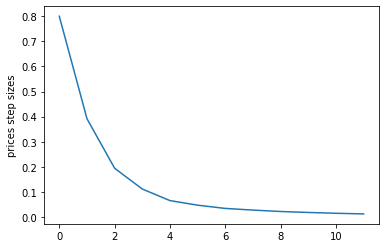

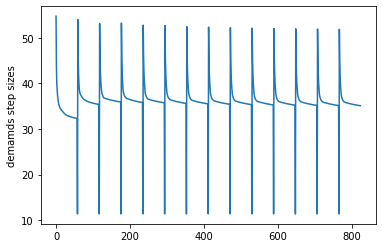

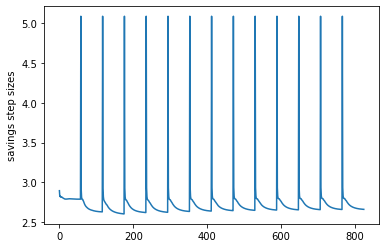

In [ ]:
num_goods = 5
num_buyers = 5
num_samples = 25
discount = 0.9

valuations = np.array([[0.50722067, 0.76313337, 0.05360443, 0.7501781,  0.67800042],
 [0.2274455,  0.06174344, 0.39171342, 0.1402779,  0.15473259],
 [0.16527965, 0.3476444,  0.36241701, 0.99000073, 0.75359852],
 [0.34999164, 0.68091931, 0.0310125,  0.17069236, 0.03813618],
 [0.02829523, 0.34238797, 0.69479688, 0.45690191, 0.4699344 ]])


valuations = valuations * 5



num_iters_prices = 40
num_iters_demands = 60

value_coef = np.zeros(5)
value_intercept = 0


budgets = np.array([9.09845395, 9.18667045, 9.2, 10, 10])


utility_type = "linear"


learn_rate_prices = 1.7
learn_rate_demands = 0.02

print(learn_rate_prices)
print(learn_rate_demands)


prices_step_sizes, demands_step_sizes, savings_step_sizes = min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, 
                                                                                 discount, learn_rate_prices, learn_rate_demands, 
                                                                                num_iters_prices, num_iters_demands, utility_type, test=True)
plt.plot(prices_step_sizes[1:])
plt.ylabel("prices step sizes")
plt.show()

plt.plot(demands_step_sizes[1:])
plt.ylabel("demamds step sizes")
plt.show()

plt.plot(savings_step_sizes[1:])
plt.ylabel("savings step sizes")
plt.show()



#### Value Iteration

In [ ]:
# The main function for value iteration
def fitted_linear_val_iter(valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands,
                                                                    num_iters_VI, num_iters_prices,  num_iters_demands, 
                                                                    num_samples, utility_type):
    coef_hist = [value_coef]
    intercept_hist = [value_intercept]
    values_hist = []
    budgets_hist = []
    
    num_buyers = valuations.shape[0]
    num_goods = valuations.shape[1]

    budgets_samples = np.random.uniform(9, 10, (num_samples, num_buyers))
    for iter in range(num_iters_VI):
        print(f"----------Value Iteration {iter}------------")
        values = []
        
        for index, budgets in enumerate(budgets_samples): 
            print(f"_____Sample {index}_____")
            value, prices, allocations, savings = min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, 
                                                                                   discount, learn_rate_prices, learn_rate_demands, 
                                                                                   num_iters_prices, num_iters_demands, utility_type, test=False)
            values.append(value)
        
        values = np.array(values)
        

        reg = linear_model.LinearRegression()
        reg.fit(budgets_samples, values)
        value_coef = reg.coef_ # Update the parameters
        value_intercept = reg.intercept_ # Update the intercept
        
        coef_hist.append(value_coef)
        intercept_hist.append(value_intercept)
        values_hist.append(values)
        budgets_hist.append(budgets_samples)

        print("value coef:", value_coef)
        print("value_intercept:", value_intercept)
        print("---------------------------------------------------------------------------------------------------------")

        # coef_hist_filename = f"/content/drive/My Drive/exp_results_{utility_type}_new_valfunc/coef_hist_{iter}_{utility_type}_fisher.npy"
        # intercept_hist_filename = f"/content/drive/My Drive/exp_results_{utility_type}_new_valfunc/intercept_hist_{iter}_{utility_type}_fisher.npy"
        # values_hist_filename = f"/content/drive/My Drive/exp_results_{utility_type}_new_valfunc/values_hist_{iter}_{utility_type}_fisher.npy"
        # budgets_hist_filename = f"/content/drive/My Drive/exp_results_{utility_type}_new_valfunc/budgets_hist_{iter}_{utility_type}_fisher.npy"
        # with open(coef_hist_filename, 'wb') as f:
        #     np.save(f, coef_hist)

        # with open(intercept_hist_filename, 'wb') as f:
        #     np.save(f, intercept_hist)

        # with open(values_hist_filename, 'wb') as f:
        #     np.save(f, values_hist)


        # with open(budgets_hist_filename, 'wb') as f:
        #     np.save(f, budgets_hist)

    return (coef_hist, intercept_hist, values_hist, budgets_hist)


### Experiments

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

num_goods = 5
num_buyers = 5
discount = 0.9
value_coef = np.repeat(0, num_buyers)
value_intercept = 0


valuations = np.array([[0.50722067, 0.76313337, 0.05360443, 0.7501781,  0.67800042],
 [0.2274455,  0.06174344, 0.39171342, 0.1402779,  0.15473259],
 [0.16527965, 0.3476444,  0.36241701, 0.99000073, 0.75359852],
 [0.34999164, 0.68091931, 0.0310125,  0.17069236, 0.03813618],
 [0.02829523, 0.34238797, 0.69479688, 0.45690191, 0.4699344 ]])


valuations = valuations * 5

learn_rate_prices = 1.7
learn_rate_demands = 0.02
num_iters_VI = 30
num_iters_prices = 60
num_iters_demands = 60
num_samples = 15



coef_hist_linear, intercept_hist_linear, values_hist_linear, budgets_hist_linear = fitted_linear_val_iter(valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands,
                                                                    num_iters_VI, num_iters_prices, num_iters_demands, 
                                                                    num_samples, "linear")

# coef_hist_leontief, intercept_hist_leontief, values_hist_leontief, budgets_hist_leontief = fitted_linear_val_iter(valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands,
#                                                                     num_iters_VI, num_iters_prices, num_iters_demands, 
#                                                                     num_samples, "leontief")

# coef_hist_cd, intercept_hist_cd, values_hist_cd, budgets_hist_cd = fitted_linear_val_iter(valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
#                                                                     num_iters_VI, num_iters_prices, num_iters_demands, 
#                                                                     num_samples, "cd")


Streaming output truncated to the last 5000 lines.
excess demands: [-0.00255608 -0.00462917 -0.00515986 -0.00447888 -0.00349456]
value coef: [2.36533204 1.46887216 2.55702133 2.11521679 2.00170984]
value_intercept: 660.1641470347124
---------------------------------------------------------------------------------------------------------
----------Value Iteration 14------------
_____Sample 0_____

****Min-Max Price Iteration 10****
Early end! Excess demand norm: 0.009418816216656235
------------------------------------------------------------------
budgets: [9.36485638 9.68092042 9.72847154 9.72323907 9.83277991]
demands: [[2.54570996e-01 1.89775915e-01 2.68017097e-09 2.69304226e-01
  3.19599344e-01]
 [5.45847372e-01 3.81686896e-09 4.70232149e-01 6.04678692e-09
  8.17135527e-09]
 [6.17450375e-09 5.27274106e-09 4.12228695e-09 7.14470021e-01
  2.95876369e-01]
 [1.96273325e-01 8.06101069e-01 2.83188521e-09 4.97560685e-09
  4.10170231e-09]
 [5.06130119e-09 9.66433362e-09 5.24323849e-01 1.10

#### Save results

In [ ]:
print(coef_hist_linear)
print(intercept_hist_linear)

[array([0, 0, 0, 0, 0]), array([2.36389049, 1.46885989, 2.55794935, 2.11611784, 2.00125919]), array([2.36527284, 1.46890872, 2.55699344, 2.11528301, 2.00168519]), array([2.36523539, 1.46891545, 2.55701889, 2.11529184, 2.00170119]), array([2.36520912, 1.46888778, 2.55702563, 2.11530038, 2.00168851]), array([2.36521044, 1.46886386, 2.55703654, 2.11529328, 2.00169477]), array([2.36521075, 1.46890646, 2.55702634, 2.11530611, 2.00169311]), array([2.36533803, 1.46888324, 2.55702091, 2.1153173 , 2.00169574]), array([2.36522339, 1.46894282, 2.55706043, 2.11532027, 2.00170103]), array([2.36525127, 1.46889382, 2.55699136, 2.11528213, 2.00166579]), array([2.36526281, 1.46886452, 2.55701394, 2.11519661, 2.00169471]), array([2.36528837, 1.46883895, 2.55702118, 2.11521618, 2.00175983]), array([2.36526295, 1.46890918, 2.55698381, 2.11523816, 2.0017107 ]), array([2.36526373, 1.46890743, 2.55702184, 2.11535629, 2.00163186]), array([2.36533204, 1.46887216, 2.55702133, 2.11521679, 2.00170984]), array([2.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


#### Save Linear data ##### 

with open('/content/drive/My Drive/exp_results/jax_savings_big/coef_hist_linear_fisher.npy', 'wb') as f:
    np.save(f, coef_hist_linear)

with open('/content/drive/My Drive/exp_results/jax_savings_big/intercept_hist_linear_fisher.npy', 'wb') as f:
    np.save(f, intercept_hist_linear)

with open('/content/drive/My Drive/exp_results/jax_savings_big/values_hist_linear_fisher.npy', 'wb') as f:
    np.save(f, values_hist_linear)

with open('/content/drive/My Drive/exp_results/jax_savings_big/budgets_hist_linear_fisher.npy', 'wb') as f:
    np.save(f, budgets_hist_linear)


# ##### Save Cobb-Douglas data #####
# with open('/content/drive/My Drive/exp_results_cd/coef_hist_cd_fisher.npy', 'wb') as f:
#     np.save(f, coef_hist_cd)

# with open('/content/drive/My Drive/exp_results_cd/intercept_hist_cd_fisher.npy', 'wb') as f:
#     np.save(f, intercept_hist_cd)

# with open('/content/drive/My Drive/exp_results_cd/values_hist_cd_fisher.npy', 'wb') as f:
#     np.save(f, values_hist_cd)


# ##### Save Leontief data ##### 
# with open('/content/drive/My Drive/exp_results/budgets_hist_cd_fisher.npy', 'wb') as f:
#     np.save(f, budgets_hist_cd)

# with open('/content/drive/My Drive/exp_results/coef_hist_leontief_fisher.npy', 'wb') as f:
#     np.save(f, coef_hist_leontief)

# with open('/content/drive/My Drive/exp_results/intercept_hist_leontief_fisher.npy', 'wb') as f:
#     np.save(f, intercept_hist_leontief)

# with open('/content/drive/My Drive/exp_results/values_hist_leontief_fisher.npy', 'wb') as f:
#     np.save(f, values_hist_leontief)

# with open('/content/drive/My Drive/exp_results/budgets_hist_leontief_fisher.npy', 'wb') as f:
#     np.save(f, budgets_hist_leontief)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
